<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---
 

#### Q1. You need to build a reliable estimator/model for the price of the house given characteristics of the house that CANNOT be renovated. 


#### Some examples of fixed and renovateble featurs include:

#### Fixed features
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

 

#### Renovateable features:(these are some examples of renovateable features that you will include in your model for question two)
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

 

### **Your goals for question one:**
 - Perform any cleaning, feature engineering, and EDA you deem necessary.
 - Be sure to remove any houses that are not residential from the dataset.
 - Identify **fixed** features that can predict price.
 - Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
 - Characterize your model. How well does it perform? What are the best estimates of price?

## NOTEBOOK OVERVIEW

#### > read in processed data from EDA and standardised all. 
#### > used CV wrapper on Lasso, Ridge, and SVR to identify the best parameters
#### > attempted with polynomial feature preprocessing but did not get a good score
#### > ran all model with best parameters with cross validation on training data
#### > get score for test data
#### > plot the residuals again predictions to under the randomness of residuals
#### > extract features of all 3 models and inspect their agreement on feature importance
#### > drew conclusion on feature coefficient, see the end of notebook
#### > picked Lasso model to move on to question 2

## feature selection, only perform on training data

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
X_train = pd.read_csv('./processed data/X_train_fixed.csv',index_col=0)
X_test = pd.read_csv('./processed data/X_test_fixed.csv',index_col=0)
y_train = pd.read_csv('./processed data/y_train.csv',index_col=0)
y_train = y_train.SalePrice
y_test = pd.read_csv('./processed data/y_test.csv',index_col=0)
y_test = y_test.SalePrice

In [3]:
# standardise
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [4]:
Xs_train.shape, Xs_test.shape

((1278, 473), (172, 473))

In [5]:
Xs_train

array([[-0.2363435 , -0.20291472,  0.48799701, ..., -0.11952286,
         0.47837867, -0.31894222],
       [ 0.43340056, -0.09232906, -0.57309913, ..., -0.11952286,
         0.47837867, -0.31894222],
       [-0.10239469,  0.06633733,  0.30392931, ..., -0.11952286,
         0.47837867, -0.31894222],
       ...,
       [-0.37029232, -0.2942681 , -0.57309913, ..., -0.11952286,
         0.47837867, -0.31894222],
       [-0.37029232, -0.25416877, -0.57309913, ..., -0.11952286,
         0.47837867, -0.31894222],
       [ 0.21015254, -0.05992265, -0.57309913, ..., -0.11952286,
         0.47837867, -0.31894222]])

### try LassoCV, Lasso
    - use LassoCV wrapper to get best alpha
    - assign the best alpha to a Lasso model
    - use cross validation to get the R2 scores
    - score on test dataset
    - inspect the coefficients of top features

In [6]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score

# 10 folds
lasso_cv_10 = LassoCV(n_alphas = 250, cv = 10).fit(Xs_train, y_train)
lasso_cv_10.alpha_

1438.0727761675964

In [7]:
lasso_cv_10.score(Xs_test, y_test)

0.8676288605447531

In [9]:
# 5 folds
lasso_cv_5 = LassoCV(n_alphas = 250, cv = 5).fit(Xs_train, y_train)
lasso_cv_5.alpha_

1606.8437057152246

In [10]:
lasso_cv_5.score(Xs_test, y_test)

0.8668418440990135

In [11]:
lasso_scores = cross_val_score(lasso_cv_10, Xs_train, y_train, cv = 10)
lasso_scores.mean(), lasso_scores.std()

(0.7943093476848058, 0.11636107400468057)

In [12]:
lasso_features = pd.DataFrame({'feature': X_train.columns,
                              'lasso_coef': lasso_cv_10.coef_,
                              'lasso_abs_coef': abs(lasso_cv_10.coef_)})

lasso_features.sort_values(by = 'lasso_abs_coef', ascending=False)[:20]

,feature,lasso_coef,lasso_abs_coef
9,GrLivArea,24604.664236,24604.664236
443,GarageCars_3,10892.132738,10892.132738
59,Neighborhood_NridgHt,9724.906519,9724.906519
58,Neighborhood_NoRidge,6191.001162,6191.001162
322,KitchenAbvGr_1,6190.641443,6190.641443
6,TotalBsmtSF,6113.783372,6113.783372
65,Neighborhood_StoneBr,6085.092051,6085.092051
312,FullBath_3,5494.396662,5494.396662
293,Foundation_PConc,4970.917048,4970.917048
301,BsmtExposure_Gd,4856.012736,4856.012736


### try RidgeCV, Ridge
    - use RidgeCV wrapper to get best alpha
    - assign best alpha to Ridge
    - use cross validation to get the R2 scores
    - score on test dataset
    - inspect the coefficients of top features

In [14]:
from sklearn.linear_model import Ridge, RidgeCV

r_alphas = np.logspace(0,5,100)

# 5 folds
r_cv_5 = RidgeCV(alphas = r_alphas, cv = 5).fit(Xs_train, y_train)
r_cv_5.alpha_,r_cv_5.best_score_

(849.7534359086438, 0.7869227254254486)

In [15]:
r_cv_5.score(Xs_test, y_test)

0.8567359914924593

In [16]:
# 10 folds
r_cv_10 = RidgeCV(alphas = r_alphas, cv = 10).fit(Xs_train, y_train)
r_cv_10.alpha_,r_cv_10.best_score_

(849.7534359086438, 0.8005725256060119)

In [17]:
r_cv_10.score(Xs_test, y_test)

0.8567359914924593

In [18]:
ridge_scores = cross_val_score(r_cv_10, Xs_train, y_train, cv=10)
ridge_scores.mean(), ridge_scores.std()

(0.7967620923780371, 0.09888983529804139)

In [19]:
ridge_features = pd.DataFrame({'feature': X_train.columns,
                              'ridge_coef': r_cv_10.coef_,
                              'ridge_abs_coef': abs(r_cv_10.coef_)})

ridge_features.sort_values(by = 'ridge_abs_coef', ascending=False, inplace=True)

In [20]:
ridge_features[:20]

,feature,ridge_coef,ridge_abs_coef
9,GrLivArea,6922.584676,6922.584676
443,GarageCars_3,6188.539010,6188.539010
7,1stFlrSF,5618.305098,5618.305098
59,Neighborhood_NridgHt,5508.634249,5508.634249
312,FullBath_3,5148.047461,5148.047461
58,Neighborhood_NoRidge,4874.261555,4874.261555
6,TotalBsmtSF,4667.095084,4667.095084
332,TotRmsAbvGrd_10,4446.740538,4446.740538
337,Fireplaces_2,4321.625024,4321.625024
65,Neighborhood_StoneBr,4242.260136,4242.260136


#### try linear regression
    - preprocessing data with PolyNomial Features
    - test on LinearRegression
    - cross validation on the model and get the scores

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)
Xs_train_poly = poly.fit_transform(Xs_train)
Xs_test_poly = poly.transform(Xs_test)

lr = LinearRegression()
lr.fit(Xs_train_poly, y_train)
lr.score(Xs_test_poly, y_test)


0.8090907122133338

In [18]:
lr_scores = cross_val_score(lr, Xs_train_poly, y_train, cv = 10)
lr_scores.mean(), lr_scores.std()

(0.6884796885864702, 0.12645613735531364)

In [19]:
# TASK TO SOLVE: how to flat the coefficients after polynomial to understand the importance of features?

### try SVR
    - GridSearch the best C for SVR
    - Cross Validate and get the scores
    - get test score
    - inspect coefficients

In [21]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

Cs = {'C':[10,100,1000]}
svr = SVR(kernel = 'linear')
svr_gs = GridSearchCV(svr, param_grid=Cs, cv = 10)
svr_gs.fit(Xs_train, y_train)

GridSearchCV(cv=10, estimator=SVR(kernel='linear'),
             param_grid={'C': [10, 100, 1000]})

In [22]:
svr_gs.best_params_

{'C': 100}

In [23]:
svr_gs.score(Xs_test, y_test)

0.8657647908285638

In [25]:
svr_scores = cross_val_score(svr_gs.best_estimator_, Xs_train, y_train, cv = 10)
svr_scores.mean(), svr_scores.std()

(0.8086644697011556, 0.11108711533216696)

In [26]:
svr_gs.best_estimator_.coef_.shape

(1, 473)

In [29]:
svr_coef = svr_gs.best_estimator_.coef_.reshape(473)

In [30]:
svr_features = pd.DataFrame({'feature': X_train.columns,
                              'svr_coef': svr_coef,
                              'svr_abs_coef': abs(svr_coef)})

svr_features.sort_values(by = 'svr_abs_coef', ascending=False, inplace=True)
svr_features[:20]

,feature,svr_coef,svr_abs_coef
9,GrLivArea,9195.296627,9195.296627
7,1stFlrSF,7624.391426,7624.391426
6,TotalBsmtSF,6852.348633,6852.348633
3,BsmtFinSF1,6222.231393,6222.231393
443,GarageCars_3,5617.741667,5617.741667
58,Neighborhood_NoRidge,4640.787751,4640.787751
8,2ndFlrSF,4615.101138,4615.101138
1,LotArea,4503.904527,4503.904527
59,Neighborhood_NridgHt,4353.066827,4353.066827
65,Neighborhood_StoneBr,4132.025002,4132.025002


In [31]:
svr_features[svr_features.svr_abs_coef == 0]

,feature,svr_coef,svr_abs_coef
257,YearRemodAdd_2010,0.0,0.0
359,GarageYrBlt_1927,0.0,0.0
87,YearBuilt_1875,0.0,0.0
459,YrSold_2010,0.0,0.0
197,YearBuilt_2010,0.0,0.0
440,GarageYrBlt_2010,0.0,0.0
263,Exterior1st_AsphShn,0.0,0.0


### plot residuals of lasso, ridge, SVR
    - plot train and test residuals on each model

In [33]:
lasso_train_preds = lasso_cv_10.predict(Xs_train)
lasso_test_preds = lasso_cv_10.predict(Xs_test)

lasso_train_residuals = y_train - lasso_train_preds
lasso_test_residuals = y_test - lasso_test_preds

In [34]:
ridge_train_preds = r_cv_10.predict(Xs_train)
ridge_test_preds = r_cv_10.predict(Xs_test)

ridge_train_residuals = y_train - ridge_train_preds
ridge_test_residuals = y_test - ridge_test_preds

In [35]:
svr_train_preds = svr_gs.best_estimator_.predict(Xs_train)
svr_test_preds = svr_gs.best_estimator_.predict(Xs_test)

svr_train_residuals = y_train - svr_train_preds
svr_test_residuals = y_test - svr_test_preds

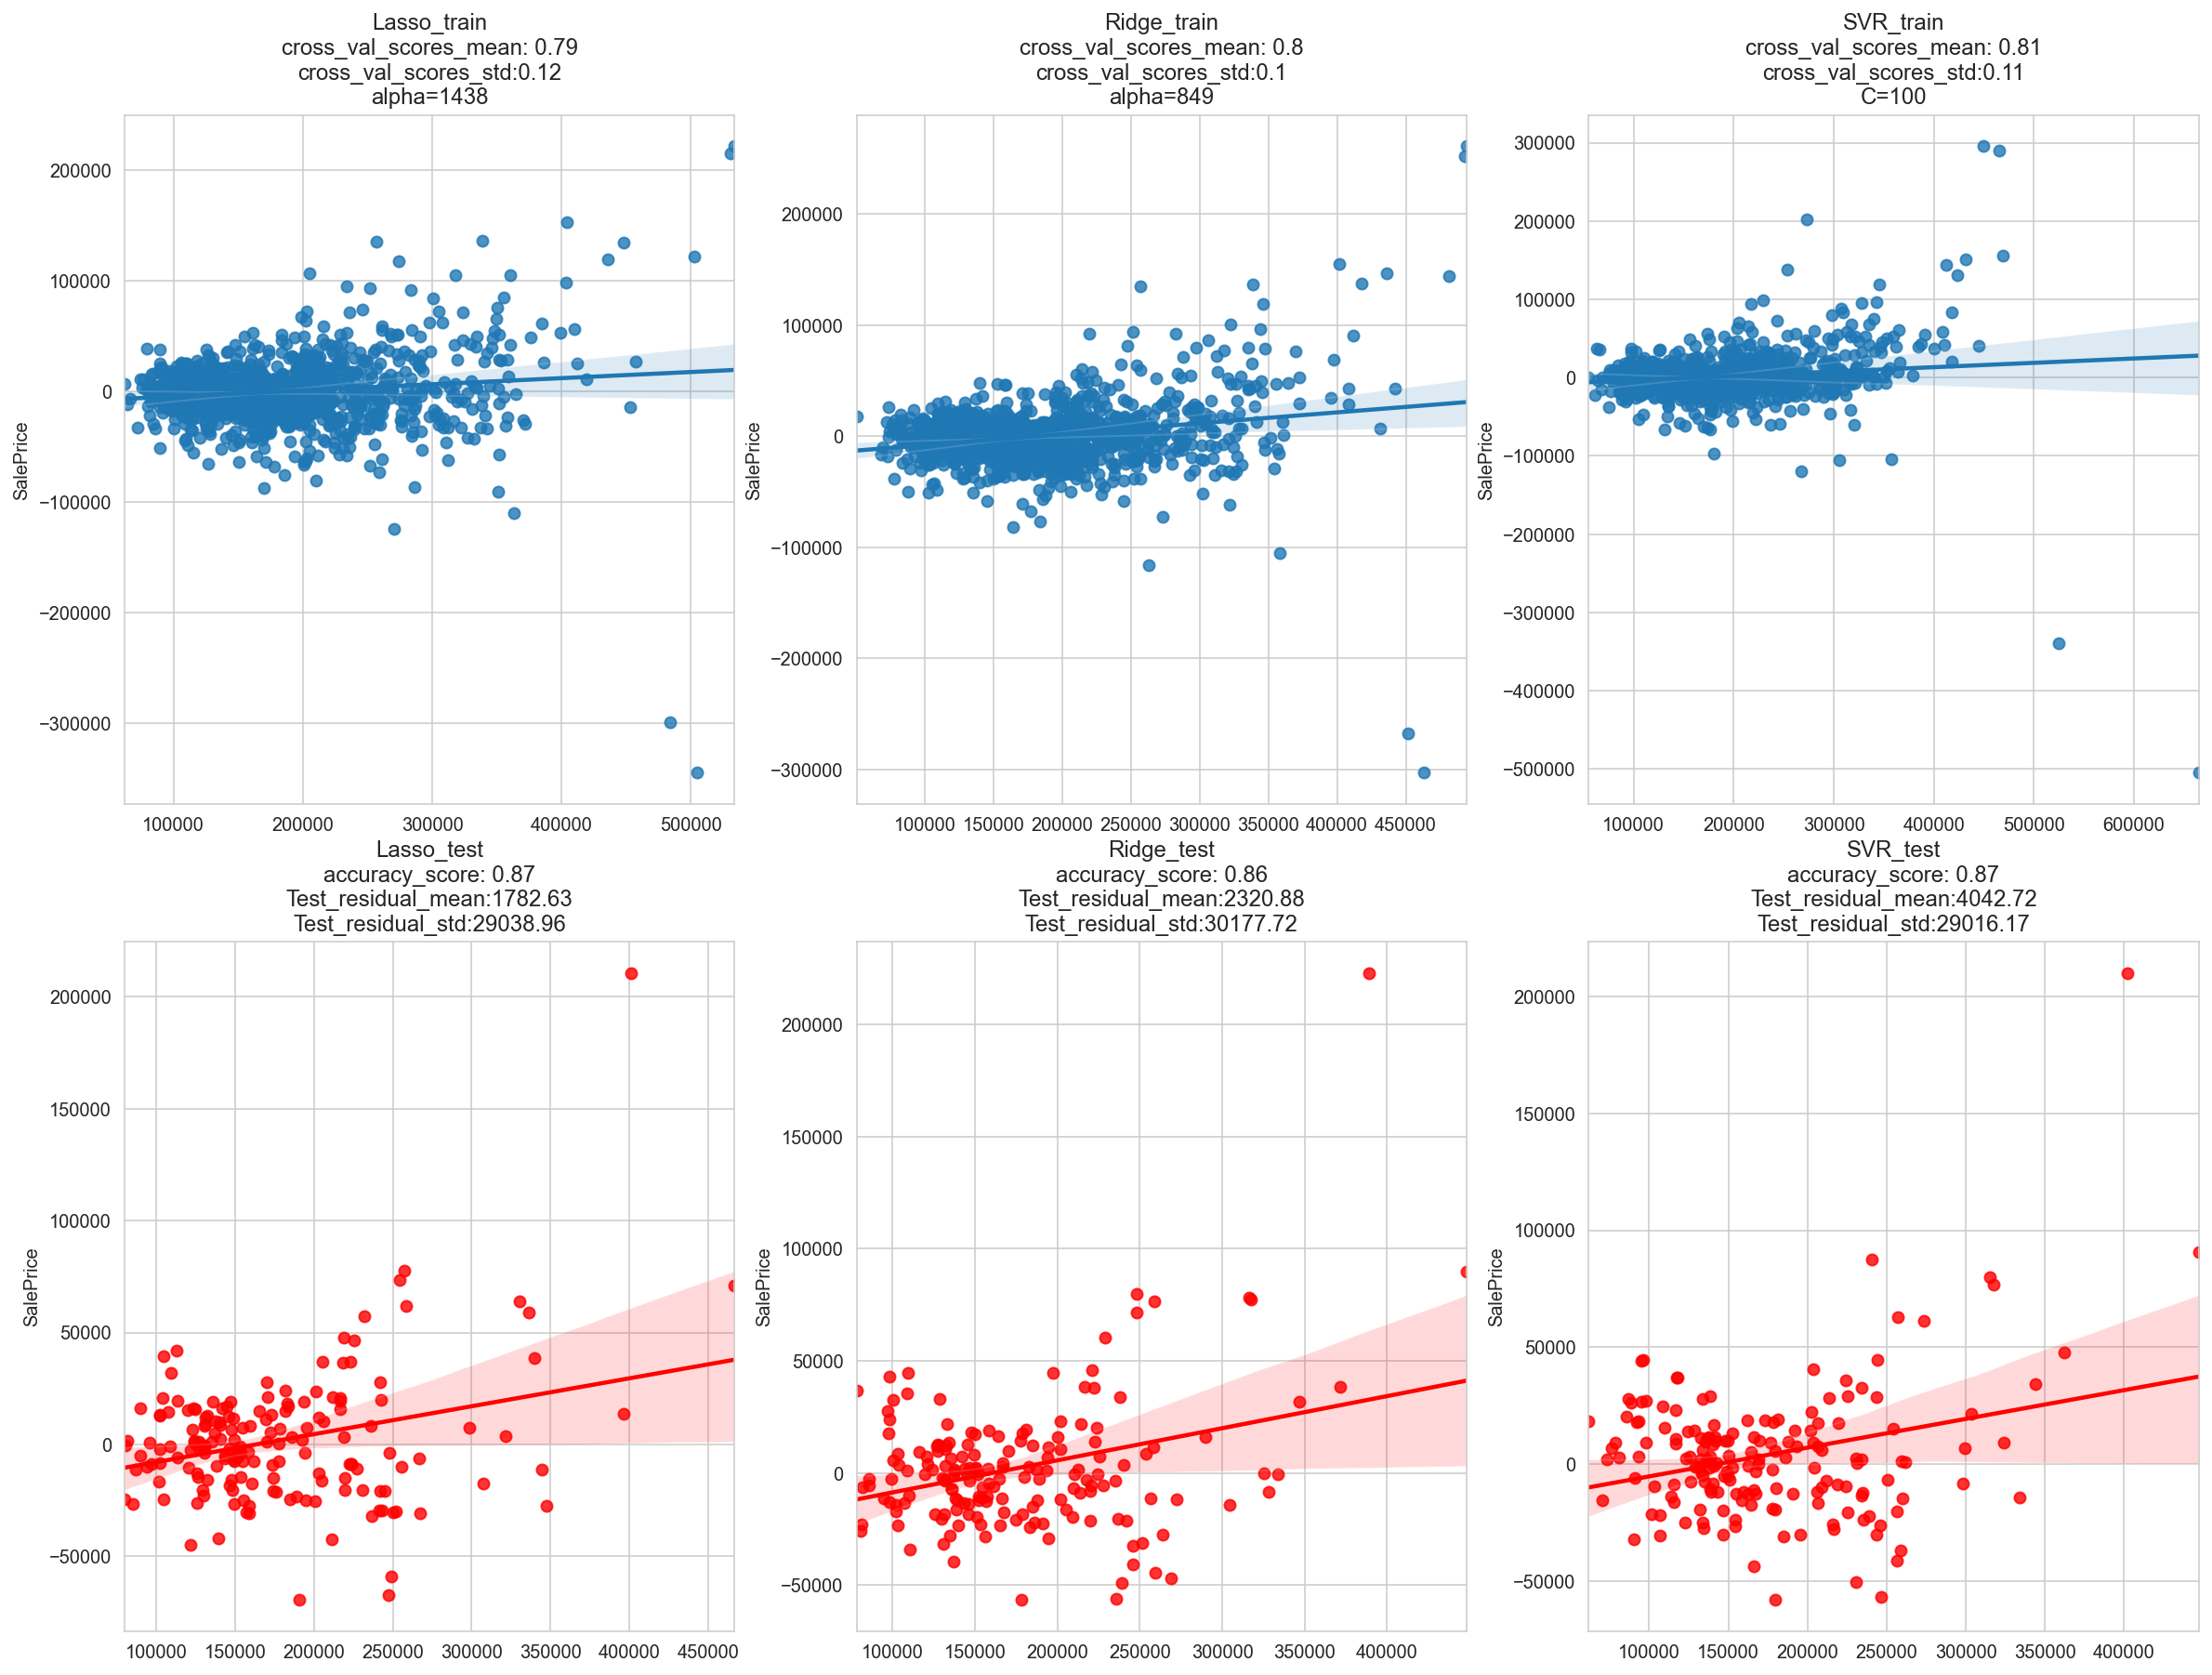

In [38]:
fig, axes = plt.subplots(2, 3, figsize = (20,15))
lasso_scores.mean(), lasso_scores.std()
sns.regplot(ax = axes[0,0], x = lasso_train_preds, y = lasso_train_residuals)
sns.regplot(ax = axes[1,0], x = lasso_test_preds, y = lasso_test_residuals, color='red')
axes[0,0].set_title(f'Lasso_train\ncross_val_scores_mean: {round(lasso_scores.mean(),2)}\ncross_val_scores_std:{round(lasso_scores.std(),2)}\nalpha=1438')
axes[1,0].set_title(f'Lasso_test\naccuracy_score: {round(lasso_cv_10.score(Xs_test, y_test),2)}\nTest_residual_mean:{round(lasso_test_residuals.mean(),2)}\nTest_residual_std:{round(lasso_test_residuals.std(),2)}')

sns.regplot(ax = axes[0,1], x = ridge_train_preds, y = ridge_train_residuals)
sns.regplot(ax = axes[1,1], x = ridge_test_preds, y = ridge_test_residuals, color='red')
axes[0,1].set_title(f'Ridge_train\ncross_val_scores_mean: {round(ridge_scores.mean(),2)}\ncross_val_scores_std:{round(ridge_scores.std(),2)}\nalpha=849')
axes[1,1].set_title(f'Ridge_test\naccuracy_score: {round(r_cv_10.score(Xs_test, y_test),2)}\nTest_residual_mean:{round(ridge_test_residuals.mean(),2)}\nTest_residual_std:{round(ridge_test_residuals.std(),2)}')

sns.regplot(ax = axes[0,2], x = svr_train_preds, y = svr_train_residuals)
sns.regplot(ax = axes[1,2], x = svr_test_preds, y = svr_test_residuals, color='red')
axes[0,2].set_title(f'SVR_train\ncross_val_scores_mean: {round(svr_scores.mean(),2)}\ncross_val_scores_std:{round(svr_scores.std(),2)}\nC=100')
axes[1,2].set_title(f'SVR_test\naccuracy_score: {round(svr_gs.best_estimator_.score(Xs_test, y_test),2)}\nTest_residual_mean:{round(svr_test_residuals.mean(),2)}\nTest_residual_std:{round(svr_test_residuals.std(),2)}');

fig.savefig('fixed_features_models.png', bbox_inches='tight')

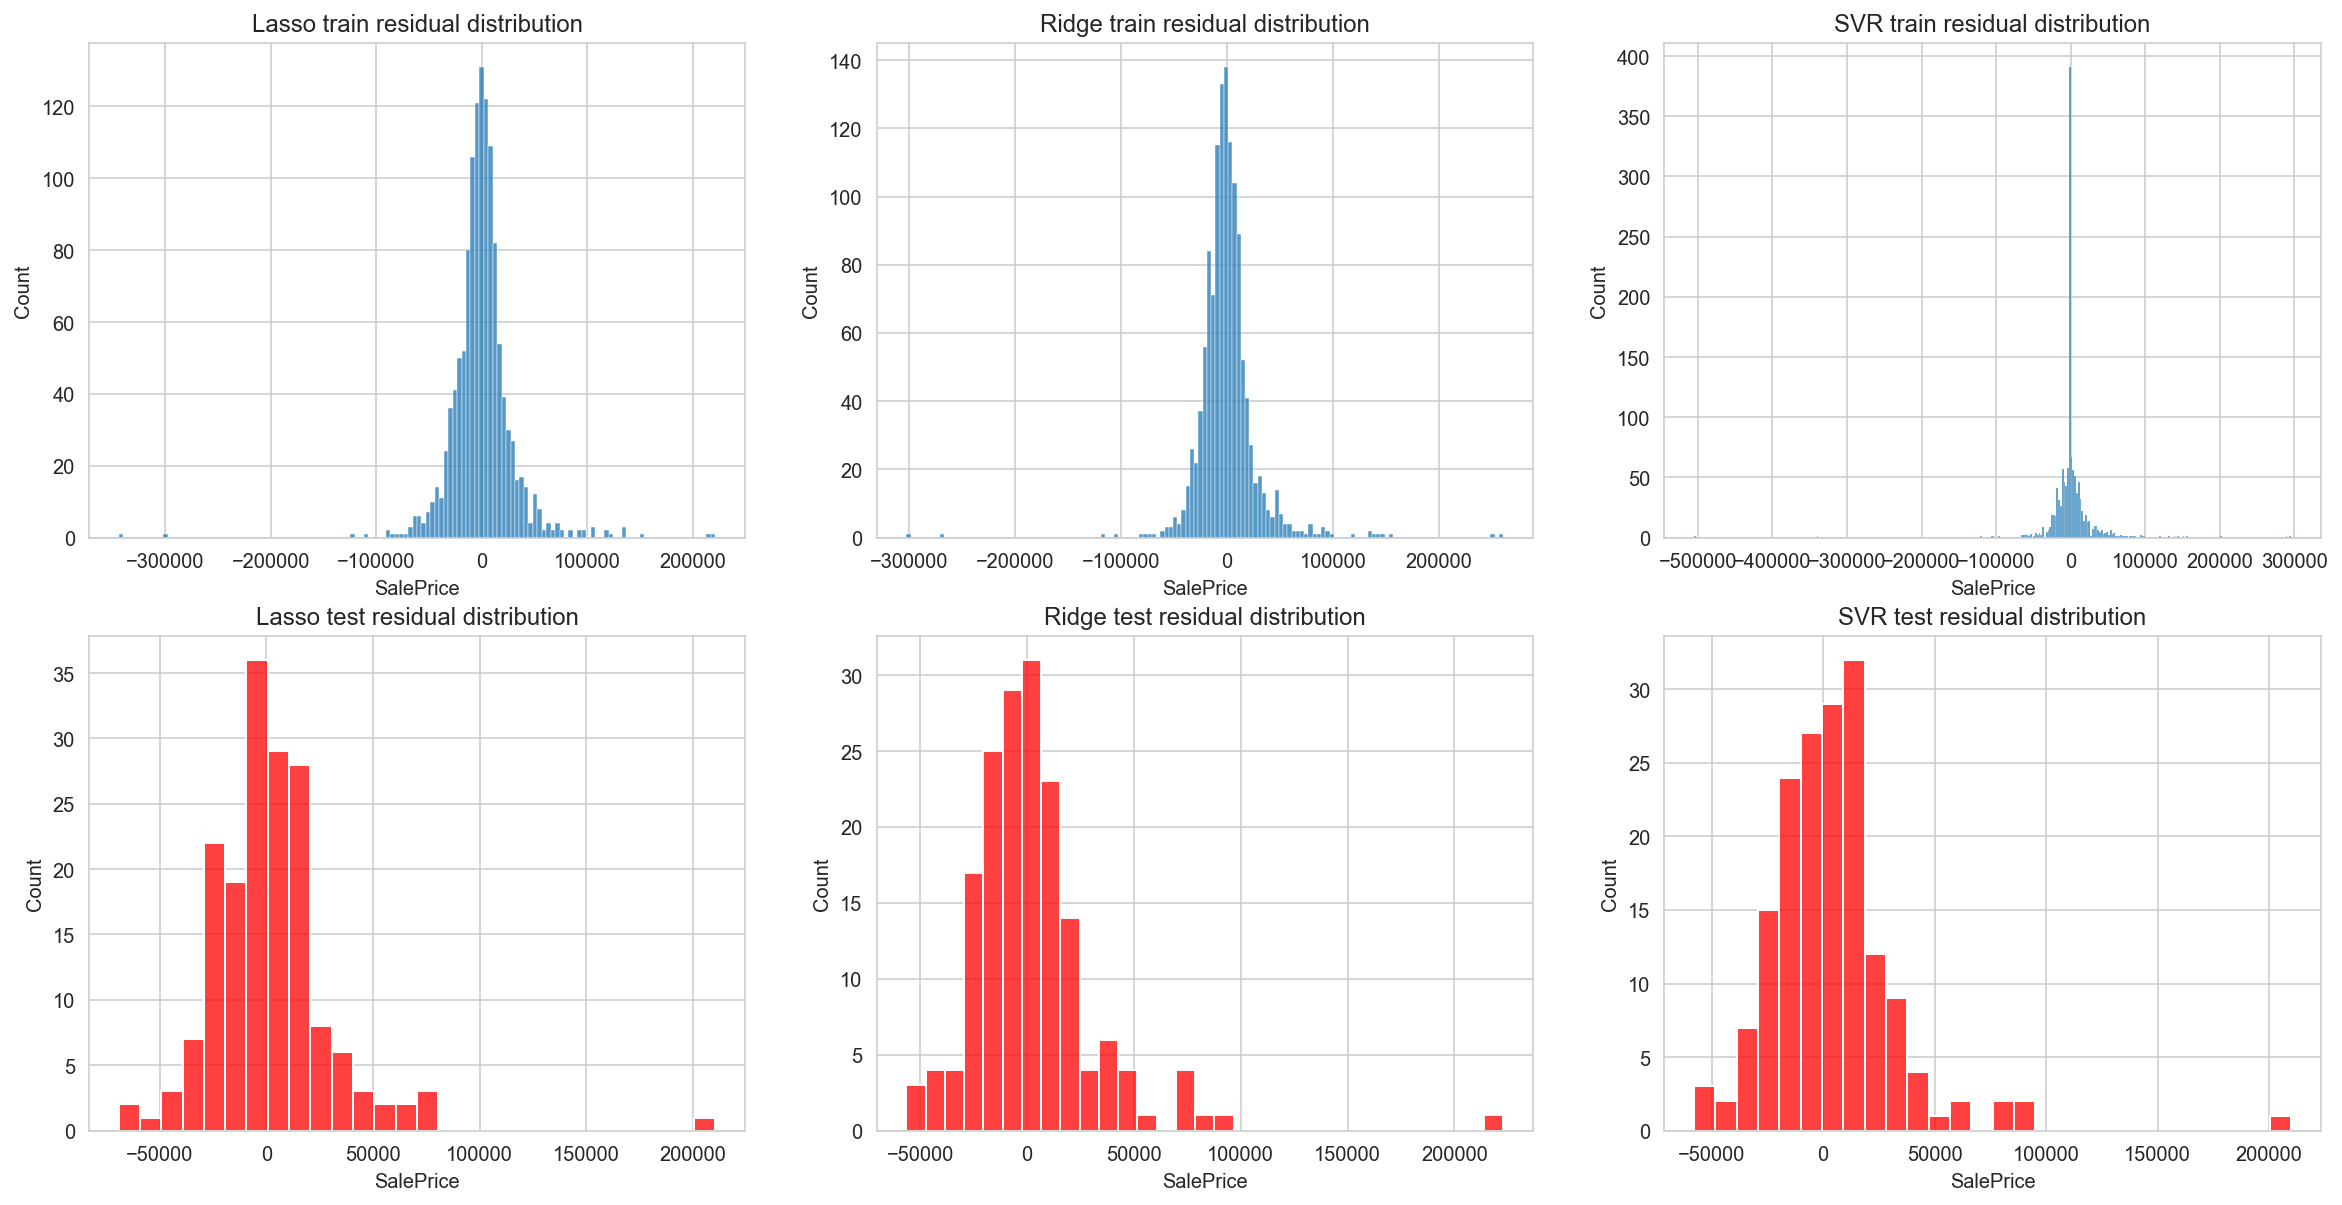

In [39]:
fig, axes = plt.subplots(2, 3, figsize = (20,10))

sns.histplot(ax = axes[0,0], data = lasso_train_residuals)
sns.histplot(ax = axes[1,0], data = lasso_test_residuals, color = 'red')
axes[0,0].set_title('Lasso train residual distribution')
axes[1,0].set_title('Lasso test residual distribution')

sns.histplot(ax = axes[0,1], data = ridge_train_residuals)
sns.histplot(ax = axes[1,1], data = ridge_test_residuals, color = 'red')
axes[0,1].set_title('Ridge train residual distribution')
axes[1,1].set_title('Ridge test residual distribution')

sns.histplot(ax = axes[0,2], data = svr_train_residuals)
sns.histplot(ax = axes[1,2], data = svr_test_residuals, color = 'red')
axes[0,2].set_title('SVR train residual distribution')
axes[1,2].set_title('SVR test residual distribution');

### inspect the features coefficients from Lasso, Ridge and SVR


In [40]:
features = pd.concat([lasso_features, ridge_features, svr_features], axis = 1, join = 'inner')

print(features.shape)
features

(473, 9)


,feature,lasso_coef,lasso_abs_coef,feature,ridge_coef,ridge_abs_coef,feature,svr_coef,svr_abs_coef
0,LotFrontage,0.000000,0.000000,LotFrontage,1033.498615,1033.498615,LotFrontage,1669.597019,1669.597019
1,LotArea,1205.457789,1205.457789,LotArea,2630.487763,2630.487763,LotArea,4503.904527,4503.904527
2,MasVnrArea,1420.449597,1420.449597,MasVnrArea,3524.413959,3524.413959,MasVnrArea,3544.210615,3544.210615
3,BsmtFinSF1,3272.229141,3272.229141,BsmtFinSF1,4012.708242,4012.708242,BsmtFinSF1,6222.231393,6222.231393
4,BsmtFinSF2,0.000000,0.000000,BsmtFinSF2,601.476486,601.476486,BsmtFinSF2,840.005619,840.005619
...,...,...,...,...,...,...,...,...,...
468,SaleCondition_AdjLand,0.000000,0.000000,SaleCondition_AdjLand,-22.305102,22.305102,SaleCondition_AdjLand,577.500244,577.500244
469,SaleCondition_Alloca,0.000000,0.000000,SaleCondition_Alloca,413.046314,413.046314,SaleCondition_Alloca,757.785908,757.785908
470,SaleCondition_Family,-0.000000,0.000000,SaleCondition_Family,-791.653680,791.653680,SaleCondition_Family,179.518623,179.518623
471,SaleCondition_Normal,0.000000,0.000000,SaleCondition_Normal,242.546723,242.546723,SaleCondition_Normal,1168.560660,1168.560660


In [41]:
lasso_top_20 = lasso_features[:20]
ridge_top_20 = ridge_features[:20]
svr_top_20 = svr_features[:20]

top_20_comparison = pd.concat([lasso_top_20, ridge_top_20, svr_top_20], axis =1)
print(top_20_comparison.shape)
top_20_comparison

(35, 9)


,feature,lasso_coef,lasso_abs_coef,feature,ridge_coef,ridge_abs_coef,feature,svr_coef,svr_abs_coef
0,LotFrontage,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,LotArea,1205.457789,1205.457789,NaN,NaN,NaN,LotArea,4503.904527,4503.904527
2,MasVnrArea,1420.449597,1420.449597,MasVnrArea,3524.413959,3524.413959,MasVnrArea,3544.210615,3544.210615
3,BsmtFinSF1,3272.229141,3272.229141,BsmtFinSF1,4012.708242,4012.708242,BsmtFinSF1,6222.231393,6222.231393
4,BsmtFinSF2,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,BsmtUnfSF,-0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
6,TotalBsmtSF,6113.783372,6113.783372,TotalBsmtSF,4667.095084,4667.095084,TotalBsmtSF,6852.348633,6852.348633
7,1stFlrSF,956.534327,956.534327,1stFlrSF,5618.305098,5618.305098,1stFlrSF,7624.391426,7624.391426
8,2ndFlrSF,0.000000,0.000000,2ndFlrSF,3339.323583,3339.323583,2ndFlrSF,4615.101138,4615.101138
9,GrLivArea,24604.664236,24604.664236,GrLivArea,6922.584676,6922.584676,GrLivArea,9195.296627,9195.296627


In [42]:
top_20_agreement = pd.concat([lasso_top_20, ridge_top_20, svr_top_20], axis = 1, join = 'inner')
top_20_v2 = top_20_agreement.drop(['feature','lasso_abs_coef','ridge_abs_coef','svr_abs_coef'], axis =1)
top_20_v2['feature'] = top_20_agreement.feature.iloc[:,0]
print(top_20_v2.shape)
top_20_v2

(7, 4)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,lasso_coef,ridge_coef,svr_coef,feature
2,1420.449597,3524.413959,3544.210615,MasVnrArea
3,3272.229141,4012.708242,6222.231393,BsmtFinSF1
6,6113.783372,4667.095084,6852.348633,TotalBsmtSF
7,956.534327,5618.305098,7624.391426,1stFlrSF
8,0.000000,3339.323583,4615.101138,2ndFlrSF
9,24604.664236,6922.584676,9195.296627,GrLivArea
10,3312.965554,4137.798664,4083.674778,GarageArea


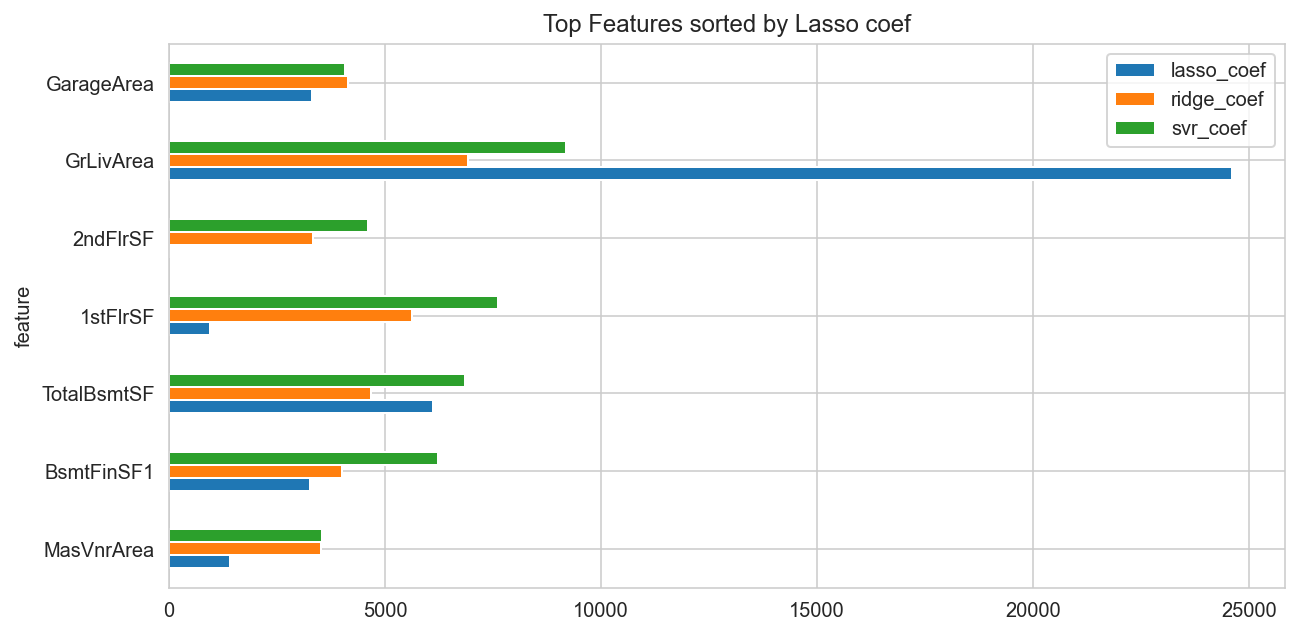

In [43]:
top_20_v2.plot(kind = 'barh', 
               x = 'feature', 
               y = ['lasso_coef','ridge_coef','svr_coef'],
               figsize = (10,5),
               title = 'Top Features sorted by Lasso coef');

In [44]:
features_comparison = lasso_features.merge(ridge_features, on = 'feature')
features_comparison = features_comparison.merge(svr_features, on = 'feature')
neg_plot = features_comparison.sort_values(by = 'lasso_coef').loc[features_comparison.lasso_coef < 0][:10]
pos_plot = features_comparison.sort_values(by = 'lasso_coef', ascending=False).loc[features_comparison.lasso_coef > 0][:10]

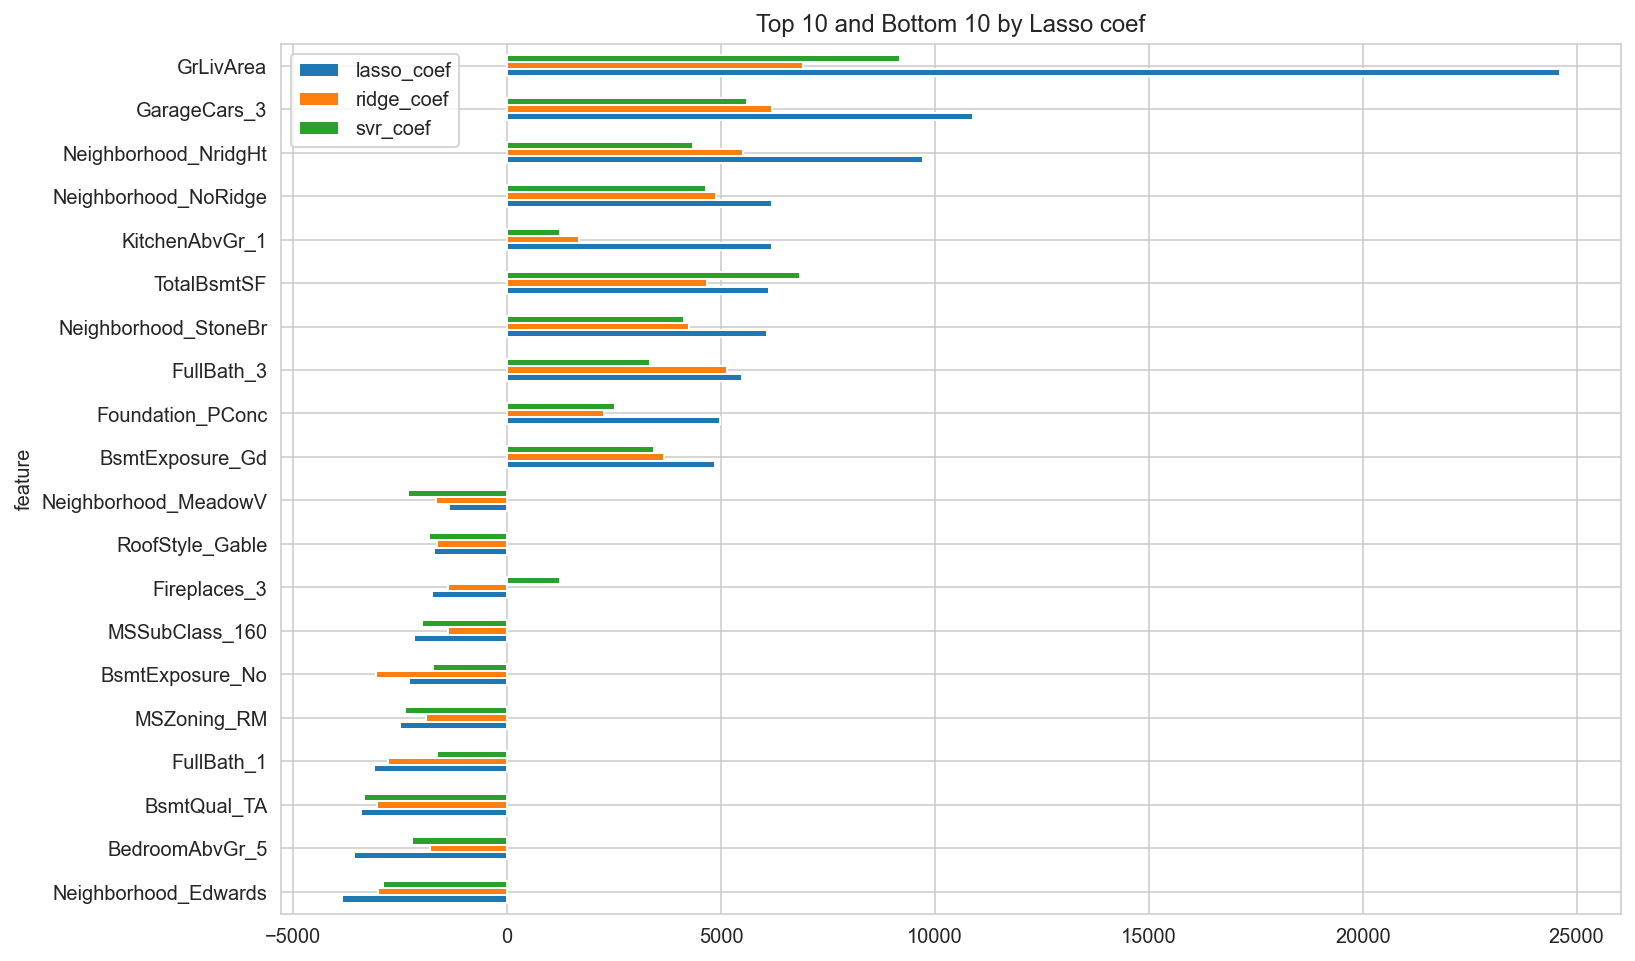

In [45]:
pd.concat([neg_plot,pos_plot]).sort_values('lasso_coef').plot(kind = 'barh', x='feature', y=['lasso_coef','ridge_coef','svr_coef'], figsize = (12,8))
plt.title('Top 10 and Bottom 10 by Lasso coef');

In [46]:
features_comparison[(features_comparison.feature == 'Foundation_PConc') | (features_comparison.feature == 'Foundation_CBlock') | (features_comparison.feature == 'Foundation_Stone')]

,feature,lasso_coef,lasso_abs_coef,ridge_coef,ridge_abs_coef,svr_coef,svr_abs_coef
292,Foundation_CBlock,-0.000000,0.000000,-1011.431187,1011.431187,-1050.851553,1050.851553
293,Foundation_PConc,4970.917048,4970.917048,2258.203977,2258.203977,2532.044628,2532.044628
295,Foundation_Stone,0.000000,0.000000,-179.173423,179.173423,84.735411,84.735411


### Conclusion:
    all 3 models agreed on many features:
    1. Neighborhood in Edwards drags down the house price while suburbs like Northridge Heights, Northridge, Stone Brook bring price up.
    2. Garage space is a big plus. Specifically, capacity of 3 cars offers great advantage to house price.
    3. Basement is a significant contributor to house price. People are looking at the overall space and paritularly finished square foot. The accessibility of basement is important too. However, the height of basement does not turn out to be positively impacting on house price in any category.
    4. Having 3 full bathrooms and 1 basement bathroom constributes to house price
    5. Having 1 or 2 fireplaces is a plus. People typically like 2 fireplaces. However, having more than 3 does not necessarily offer additional value. 
    6. Ground Living Area is of positive siginifance.
    7. Poured concrete foundation is much more popular than others foundation types. 
